## wgMLST for mbovis

* http://www3.ridom.de/seqsphere/cgmlst/
* https://www.cgmlst.org/ncs/schema/741110/
* https://jcm.asm.org/content/52/7/2479
* https://www.biorxiv.org/content/10.1101/172858v1.full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3980634/

## steps

* get MLST gene list
* assembly
* annotate
* assign allele numbers?

In [98]:
import sys,os,shutil,subprocess
import glob
import random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
import seaborn as sns
from Bio import SeqIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from io import StringIO
import pathogenie as pg
import snipgenie
from snipgenie import app,tools,wgmlst,trees
import toytree, toyplot

In [2]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
vcf_file='/storage/btbgenie/wicklow_results/filtered.vcf.gz'

In [ ]:
path = '/storage/btbgenie/mbovis_ireland/Wicklow/'
files = glob.glob(os.path.join(path,'**', '*.fastq.gz'),recursive=True)
samp = snipgenie.get_samples(files,sep='_')
pairs = pd.pivot_table(samp,index=['sample'],columns=['pair'],values='filename',aggfunc='first').reset_index()
print (pairs[:2])

## create reference proteins for MLST

In [5]:
#prots = wgmlst.make_reference_proteins()
#res = wgmlst.get_nucleotide_sequences(app.mbovis_gb,'Mbovis_AF212297_nuc.fa')

3994


## initialise MLST table from reference genome

In [63]:
def setup_db():
    """Setup initial db"""
    
    #filter only Mb proteins in scheme
    mlst=pd.read_csv('mlst_scheme.csv')
    mlst=mlst[mlst['Ridom Usage']=='MLST+']
    targets=list(mlst.Target)    
    #bovis-tb mapping
    mbmap=pd.read_csv('final_mbovis_mapping.csv')
    mbmap = mbmap[mbmap.Rv_tag.isin(targets)]
    mb_tags = list(mbmap.Mb_tag)
    #prots = tools.fasta_to_dataframe()
    #prots = prots[prots.locus_tag.isin(mb_tags)]
    nucseqs = tools.fasta_to_dataframe('Mbovis_AF212297_nuc.fa')
    nucseqs = nucseqs[nucseqs.name.isin(mb_tags)]

    #set up initial mlst table with reference sequences 
    cols = ['name','allele','sequence']
    ref = nucseqs.copy()
    ref['allele'] = 1
    ref=ref.rename(columns={'translation':'sequence'})
    ref[cols].to_csv('mbovis_db.csv.gz',index=False,compression='gzip')
    print (len(ref))    
    
setup_db()

/home/farrell/gitprojects/snipgenie/snipgenie/tools.py:385: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[key] = df[key].str.replace('|','_')


3184


## assembly

In [ ]:
assembly_path = '/storage/btbgenie/assembly/'

for i,r in pairs[5:10].iterrows():    
    name=r['sample']
    print (name)
    out = os.path.join(assembly_path,name+'.fa')
    print (out)
    spades(r[1], r[2], os.path.join(assembly_path,name), outfile=out, threads=12)

## get consensus sequence from alignment instead of assembly

In [42]:
wgmlst.get_consensus(vcf_file, '1034','consensus.fa')

The site LT708304.1:1358368 overlaps with another variant, skipping...
The site LT708304.1:1358369 overlaps with another variant, skipping...
The site LT708304.1:1358370 overlaps with another variant, skipping...
The site LT708304.1:3880152 overlaps with another variant, skipping...
The site LT708304.1:3884294 overlaps with another variant, skipping...
Applied 393 variants


## test annotatation

In [61]:
reload(wgmlst)
#seqfile='/storage/btbgenie/assembly/1034.fa'
seqfile='consensus.fa'
#featdf,recs = pg.run_annotation(seqfile, threads=10, kingdom='bacteria', trusted=wgmlst.ref_proteins)
annotfile='/storage/btbgenie/mlst_consensus_test/1034.gb'

#write out nucl sequence
SeqIO.write(recs,annotfile,'genbank')
#make nuc sequences - used for typing
outfile = '/storage/btbgenie/mlst_consensus_test/1034.fa'
res = wgmlst.get_nucleotide_sequences(annotfile,outfile,idkey='protein_id')

In [13]:
#fastafile='/storage/btbgenie/annotation_assembly/1034.fa'
#df = pg.tools.fasta_to_dataframe(fastafile)
#df[df.name=='Mb0014c']

,name,sequence,description,type
3240,Mb0014c,CTACTGGCCGAACCTCAGCGTGATGATGCCGTCCCGGTTGACGCCGGTCCCCGCCGGCGGGTTTTGATAGACGACCCGGTTGTGTTGGGAGCCACCGGCGTCGACGTCGGCCCCTTTGTCGAGCATCCCGGTCCAGCCCAGCGCGC...,Mb0014c <unknown description>,CDS


## test typing

In [68]:
prof,new = wgmlst.find_alleles(outfile)
wgmlst.update_mlst_db(new)
print (len(prof))

/home/farrell/gitprojects/snipgenie/snipgenie/tools.py:385: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[key] = df[key].str.replace('|','_')


added 0 new alleles
3184


In [102]:
reload(wgmlst)
#all typing in one go
res = wgmlst.type_sample('consensus.fa', annotfile, outfile, threads=10)

added 0 new alleles


In [103]:
res

,name,allele
0,Mb0014c,1
1,Mb0015c,1
2,Mb0016c,1
3,Mb0017c,1
4,Mb0018c,2
...,...,...
3179,Mb3936c,1
3180,Mb3937c,1
3181,Mb3938,2
3182,Mb3939,1


In [ ]:
wgmlst.get_profile_string(prof)

## profiles from assembly - not needed?

In [ ]:
profs = {}
omit=['182-MBovis','19-4281','19-2438']
samples=glob.glob(os.path.join(assembly_path,'*.fa'))
pdf=pd.DataFrame()
for s in samples:
    print (s)
    sample = os.path.splitext(os.path.basename(s))[0]    
    if sample in omit:
        continue
    profile = type_sample(s, '/storage/btbgenie/annotation_assembly/%s.fa' %sample, threads=12)
    pdf[sample] = profile['allele']
    profs[sample] = get_profile_string(profile)

## find distances between mlst profiles

In [22]:
def diff_profiles(s1, s2):    
    return sum(1 for a, b in zip(s1, s2) if a != b)

In [ ]:
import random
test = {'A':'1112233','B':'1112213','C':'2111213','D':'2111232','E':'212211','F':'2111222'}

d = wgmlst.dist_matrix(test)
wgmlst.tree_from_distmatrix(d)
tre = toytree.tree(treefile)
canvas,t,r=tre.draw(layout='r',scalebar=True,width=500)
sns.clustermap(d,figsize=(5,5))

## test on wicklow samples

In [92]:
pd.read_csv(wgmlst.mbovis_db)

,name,allele,sequence
0,Mb0014c,1,CTACTGGCCGAACCTCAGCGTGATGATGCCGTCCCGGTTGACGCCGGTCCCCGCCGGCGGGTTTTGATAGACGACCCGGTTGTGTTGGGAGCCACCGGCGTCGACGTCGGCCCCTTTGTCGAGCATCCCGGTCCAGCCCAGCGCGC...
1,Mb0015c,1,TCATTGCGCTATCTCGTATCGGGCCAGCGACGCGCGCGAATGCGGTGTCGGCGGGACAACCCAGCTTTGCAGTCCAGAATGACGTGTTTCCCCGCGTTCCGTCCAATTGAGTCGCGGGCTAGCATCAGTCCCGCCAGTGTTGCTGG...
2,Mb0016c,1,TCATGGTTCCCCCTGCAGTGCGGCTTCGATCACCGCCCGCCCGATCGGTGCCGCGAGGGCACCTCCGGTGGCGGACAGCCGATCAGCCCCGTTCTCCACCAGCACGGCAACAGCCACCTTGGGCGCTTGTGCGGGCGCAAAGGCGA...
3,Mb0017c,1,TCATACGCGTTCGATGACCTCGGTGCCGGCCGCCGTAATCGGCGACTTATTTCGTGGGCGGGTGCGCAGTGGGCGGCGGGCTCCGTGCGAGATGCGTGCCAGGATGGCCAGCAATATGTAGTTGGCCAGCAGTGAAGACCCGCCGT...
4,Mb0018c,1,TCATGCCGCCGCCCGGCAGTCGATGCCCGGCTGAGGCGGGGGTGGCGGAAGTGCGGCCATCGTCGGCGAGCTGGTGACGGGCCAAGGCGTCGGCGGCGACGCGGGCGCTGCCGGGGAGGCACTCGTGGGGATGGCAGGAGTAGTTC...
...,...,...,...
3179,Mb3936c,1,CTAAAGGCTGCTGGCGCCGTCGGCGGTGCCGTCGCCGTCGGTGTCGGTCAGCCGTACGTCCCAGCGGCCGTCGCCATCGGTGTCGACGTATCCGGTCACACGCTGCTCACCAGCACACAGCACCCGATCGGCCAGCCCGTCACCGT...
3180,Mb3937c,1,CTAGCGGTTCCCCCGTGATTTCCACCAGGACAGCAGCTCGGTTGTCGCCTCCTCGGTGGACAACGGGCCGCGCTCTAGCCGCAGCTCCTTCAAGTAGCGCCACGCCTCGCCGACTTGCGGGCCCGCCGGAATGTCGAGCACCGCCA...
3181,Mb3938,1,GTGTCCGACGGCGAACAAGCCAAATCACGTCGACGCCGGGGGCGGCGCCGCGGGCGGCGCGCTGCGGCTACAGCCGAGAATCACATGGACGCCCAACCGGCCGGCGACGCCACCCCGACCCCGGCAACGGCGAAGCGGTCCCGGTC...
3182,Mb3939,1,GTGACCGCACTGCAACTCCGCTGGGCCGCTTTGGCGCGCGTCACCTCAGCGATCGGCGTCGTGGCCGGCCTCGCGATGGCGCTCACGGTACCGTCGGCGGCACCGCACGCGCTCGCAGGCGAGCCCAGCCCGACGCCTTTTGTCCA...


In [ ]:
reload(wgmlst)
reload(tools)
omit=['182-MBovis','19-4281','19-2438']
profs = wgmlst.run_samples(vcf_file, '/storage/btbgenie/mlst_consensus_test/', threads=12, omit=omit)

In [ ]:
for i in profs:
    print (i,len(profs[i]))

## tree from profiles

In [ ]:
def make_neighbor_joining_tree(df):
    """Neighbour joining tree with biopython"""
    
    from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
    from Bio.Phylo.TreeConstruction import DistanceMatrix
    
    def lower_matrix(matrix):
        #get lower matrix as non-sparse lists
        i=0
        m=[]
        for n in range(1,matrix.shape[0]+1):
            m.append(list(x[i:i+n]))
            i+=n
        return m
    
    data = df.values
    labels = list(df.index)
    
    matrix = lower_matrix(data)
    dm = DistanceMatrix(labels, matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)
    return tree

# Create a DistanceMatrix object using a list of labels and a list of distances
labels = ['A', 'B', 'C', 'D']
matrix = [[0, 1, 2, 3], [1, 0, 4, 5], [2, 4, 0, 6], [3, 5, 6, 0]]
df = pd.DataFrame(matrix,index=labels,columns=labels)
print (df)
# Call the make_neighbor_joining_tree function to create the tree
tree = make_neighbor_joining_tree(df)

print (tree)
# Print the tree in Newick format
print(tree.format("newick"))
tre = toytree.tree(tree.format("newick"))

In [75]:
tree = wgmlst.tree_from_distmatrix(df)
print(tree.ascii_art())

          /-C
         |
         |          /-B
---------|---------|
         |          \-A
         |
          \-D


In [106]:
D = wgmlst.dist_matrix(profs)
D.to_csv('dist_mlst.csv',index=False)
#sns.clustermap(D,xticklabels=True,yticklabels=True,figsize=(6,6))
treefile='temp.newick'
tree = wgmlst.tree_from_distmatrix(D)
tree.write('tree.newick')
tre = toytree.tree('tree.newick')
tre=tre.root('43-MBovis')
canvas,t,r=tre.draw(layout='r',scalebar=True,height=600,width=800)
clusts = trees.get_clusters('tree.newick')
#clusts

TreeCluster.py  -i tree.newick -t 3 -m max_clade
TreeCluster.py  -i tree.newick -t 5 -m max_clade
TreeCluster.py  -i tree.newick -t 7 -m max_clade
TreeCluster.py  -i tree.newick -t 10 -m max_clade
TreeCluster.py  -i tree.newick -t 12 -m max_clade
TreeCluster.py  -i tree.newick -t 20 -m max_clade
TreeCluster.py  -i tree.newick -t 50 -m max_clade
TreeCluster.py  -i tree.newick -t 100 -m max_clade


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="600.0px" viewBox="0 0 800.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td8ff5b6c141a4df6afdfa00ae1101a50"> 25-MBovis 30-MBovis 14-MBovis 27-MBovis 45-MBovis 7-10423 41-MBovis 38-MBovis 52-3698 23-MBovis 51-MBovis 47-MBovis 37-MBovis 55-4348 59-6110 59-MBovis 19-MBovis 42-MBovis 48-2919 48-MBovis 49-MBovis 54-MBovis 51-3292 26-12883 3-10110 41-2165 5-10284 TB18-001924 17-MBovis 35-MBovis 1034 44-MBovis TB20-003486 cat-003488 13-11594 56-MBovis 50-MBovis 22-12200 26-MBovis 36-MBovis 24-MBovis 29-MBovis 17-11662 19-11957 31-12952 28-12935 15-11643 43-MBovis 0 5 10 15 19 24 29 34

In [107]:
tre2 = toytree.tree('/storage/btbgenie/wicklow_results/tree.newick')
#drop = list(set(tre2.get_tip_labels()) - set(tre.get_tip_labels()))
tre2=tre2.drop_tips(drop)
tre2=tre2.root('43-MBovis')
canvas,t,r=tre2.draw(layout='r',scalebar=True,height=500,width=800)
#toyplot.png.render(canvas, "snp-tree.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="500.0px" viewBox="0 0 800.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc86c7cc524c945039bc606ad0cff8659"> 59-6110 19-MBovis 42-MBovis 48-MBovis 48-2919 59-MBovis 26-12883 3-10110 55-4348 37-MBovis 52-3698 38-MBovis 41-2165 5-10284 35-MBovis 49-MBovis 54-MBovis 51-MBovis 23-MBovis 44-MBovis 45-MBovis 7-10423 41-MBovis 17-MBovis 27-MBovis 47-MBovis 25-MBovis 30-MBovis 14-MBovis 51-3292 28-12935 15-11643 19-11957 31-12952 36-MBovis 50-MBovis 26-MBovis 22-12200 56-MBovis 13-11594 17-11662 24-MBovis 29-MBovis TB20-003486 cat-003488 TB18-001924 1034 43-MBovis 0 4 7 11 14 18 22 25

# sensitivity analysis - SNPs vs MLST

## phastsim

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7987011/

In [80]:
refseq = SeqIO.read('Mbovis_AF212297.fa','fasta')
scale = (1/len(refseq))*3
#scale=8e-6
cmd = 'phastSim --outpath simulation_output/ --seed 1 --createFasta' \
         ' --createPhylip --treeFile sim.newick' \
         ' --scale {s} --invariable .1 --alpha 1.0 --omegaAlpha 1.0' \
         ' --reference Mbovis_AF212297.fa'.format(s=scale)
cmd

'phastSim --outpath simulation_output/ --seed 1 --createFasta --createPhylip --treeFile sim.newick --scale 6.896703927259084e-07 --invariable .1 --alpha 1.0 --omegaAlpha 1.0 --reference Mbovis_AF212297.fa'

In [102]:
simrecs = list(SeqIO.parse('sim_seqs3.fa','fasta'))
diff_profiles(simrecs[2].seq,simrecs[4].seq)

3

## make fastqs from sequences

In [ ]:
def make_fastq(ref, outfile, cmp=100):
    
    f1 = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/17-MBovis_S21_L001-4_R1_001.fastq.gz'
    f2 = '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/17-MBovis_S21_L001-4_R2_001.fastq.gz'
    cmd = 'java -jar /local/ArtificialFastqGenerator/ArtificialFastqGenerator.jar -O {o}'\
          ' -R {r} -S ">temp" -RL 150 -CMP {cmp} -CSD 0.2 -SE true'.format(r=ref, o=outfile,cmp=cmp,f1=f1,f2=f2) #-URQS true -F1 {f1} -F2 {f2}
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

In [ ]:
def generate_fastqs(infile, outpath):
    
    from joblib import Parallel, delayed
    import multiprocessing, time
    num_cores = 4
    
    simrecs = list(SeqIO.parse(infile,'fasta'))
    def my_func(rec):
        from tempfile import mkstemp
        x,tmp = mkstemp()
        SeqIO.write(SeqRecord(rec.seq,id='temp'), tmp, 'fasta')
        out = os.path.join(outpath,rec.id)
        make_fastq(tmp, out)

    st = time.time()
    Parallel(n_jobs=num_cores)(delayed(my_func)(i) for i in simrecs)
    print (time.time()-st)
    cmd = 'pigz %s/*.fastq' %outpath
    subprocess.check_output(cmd, shell=True)
    
generate_fastqs('sim_seqs3.fa', 'sim_fastq3')
#generate_fastqs('sim_seqs1.fa', 'sim_fastq1')

## run snipgenie on simulated fastqs

In [ ]:
import snipgenie
args = {'threads':10, 'outdir': 'sim_results3', 'labelsep':'_',
        'input':['sim_fastq3'],# 'overwrite':True,
         'species':'Mbovis-AF212297',        
         'custom_filters': True,       
         'buildtree':True}
W = snipgenie.app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
tresnps = toytree.tree('sim_results3/tree.newick')
tresnps=tresnps.root('7')
tresnps=tresnps.drop_tips('ref')
canvas,t,r=tresnps.draw(layout='r',scalebar=True,height=400,width=500,tip_labels_style={"font-size":"19px"})
sd=snpdist = pd.read_csv('sim_results3/snpdist.csv',index_col=0).iloc[1:,1:]
canvas.text(300, 20, "SNP", style={"font-size":"32px"});

#import toyplot.png
#toyplot.png.render(canvas, "snp_tree_sim.png")

In [ ]:
tresboot = toytree.mtree('sim_results3/RAxML_bootstrap.variants')
canvas,t,r=tresboot.draw(layout='r', nrows=2, ncols=5,height=400,width=700)

## mlst on simulated fastqs

In [ ]:
sim_vcf = 'sim_results3/filtered.vcf.gz'
simprofs = run_samples(sim_vcf, 'sim_mlst3', threads=12)

In [148]:
D = dist_matrix(simprofs)
D.to_csv('dist_mlst.csv')
treefile='mlst3.newick'
tree_from_distmatrix(D, treefile)
tremlst = toytree.tree(treefile)
tremlst=tremlst.root('7')
canvas,t,r=tremlst.draw(layout='r',scalebar=True,height=400,width=500,tip_labels_style={"font-size":"19px"})
canvas.text(300, 20, "wgMLST", style={"font-size":"32px"});
#toyplot.png.render(canvas, "wgmlst_tree_sim.png")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td0a1a1d4196447ad9390038956e2b263"> 3 8 1 5 9 4 6 2 7 0 2 4 6 8 wgMLST

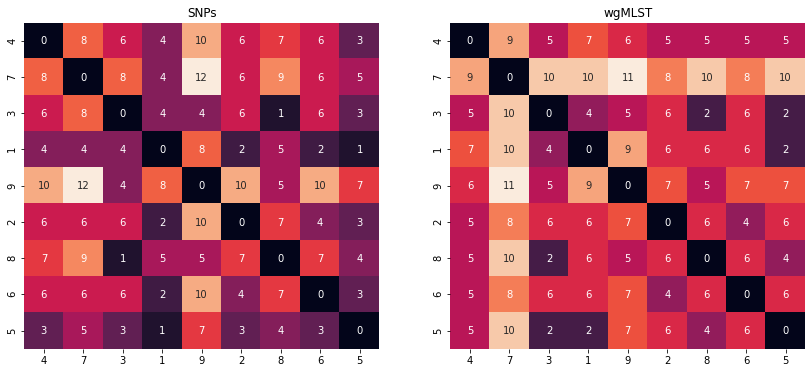

In [158]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
sns.heatmap(sd,annot=True,cbar=False,ax=ax[0])
sns.heatmap(D,annot=True,cbar=False,ax=ax[1])
ax[0].set_title('SNPs')
ax[1].set_title('wgMLST')
plt.savefig('sim_dist_heatmaps.png')

In [136]:
import dendropy
from dendropy.calculate import treecompare
tns = dendropy.TaxonNamespace()
reftree = dendropy.Tree.get(path='sim.newick', schema='newick',taxon_namespace=tns)
tree1 = dendropy.Tree.get(path='mlst3.newick', schema='newick',taxon_namespace=tns)
tree2 = dendropy.Tree.get(path='sim_results1/RAxML_bestTree.variants', schema='newick',taxon_namespace=tns)


In [138]:
print(treecompare.euclidean_distance(reftree, tree1))
print(treecompare.euclidean_distance(reftree, tree2))

4.898976053175999
5.389472890360061
